In [3]:
import torch
import torch.nn.functional as f
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
clean_hin_dataset = open("datasets\cleaned_hinenglish.txt").read().splitlines()

In [30]:
#building the mappings like tokeniser

clean = sorted(set(''.join(clean_hin_dataset)))
stoi = {s:i for i,s in enumerate(clean)}
stoi['.'] = 27
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
data_size = len(clean_hin_dataset)
hidden_size = 100


In [49]:
# Convert all text into a single string
full_text = ' '.join(clean_hin_dataset)
full_text_idx = [stoi[ch] for ch in full_text]  # Convert to indices

seq_length = 25  # sliding window size
Xtrain, Ytrain = [], []

for i in range(len(full_text_idx) - seq_length):
    Xtrain.append(full_text_idx[i : i + seq_length])
    Ytrain.append(full_text_idx[i + 1 : i + seq_length + 1])

Xtrain = torch.tensor(Xtrain, dtype=torch.long)
Ytrain = torch.tensor(Ytrain, dtype=torch.long)

print("Xtrain shape:", Xtrain.shape)  # (num_examples, 25)
print("Ytrain shape:", Ytrain.shape)  # (num_examples, 25)

Xtrain shape: torch.Size([131399, 25])
Ytrain shape: torch.Size([131399, 25])


In [ ]:
g = torch.Generator().manual_seed(2347243647 + 10)
Wxh = torch.randn((hidden_size, vocab_size), generator=g ) * 0.01    # (100,28)
Whh = torch.randn((hidden_size, hidden_size), generator=g ) * 0.01  # (100,100)
Why = torch.randn((vocab_size, hidden_size), generator=g) * 0.01  # (28,100)
bh = torch.zeros((hidden_size, 1)) # hidden bias (100,1)
by = torch.zeros((vocab_size, 1)) # output bias (28,1)
parameters = [Wxh, Whh, Why, bh, by]
count = 0

for p in parameters:
    count += p.nelement();
count;

In [57]:
for p in parameters:
    p.requires_grad = True  # Enable gradient tracking for all parameters

In [58]:
steps, lossi = [], []

In [10]:
X.shape, Y.shape

NameError: name 'X' is not defined

In [48]:
idx = torch.randint(0, len(Xtrain), (1,))


X= Xtrain[idx[0]]
Y = Ytrain[idx[0]]


X, Y

(tensor([ 1,  9,  0,  9, 14,  0,  4,  5,  7, 18,  5,  5, 19,  0,  3,  0,  1, 10,
          0, 11,  9, 20, 14,  9,  0]),
 tensor([ 9,  0,  9, 14,  0,  4,  5,  7, 18,  5,  5, 19,  0,  3,  0,  1, 10,  0,
         11,  9, 20, 14,  9,  0,  7]))

In [59]:
seq_length = 25
batch_size = 32
xs, hs, ys, ps = {}, {}, {}, {}
# X = Xtrain[0]   #25
# Y = Ytrain[0] #25

#initialise hprev to zeros
hs[-1] = torch.zeros((hidden_size, 1))
for i in range(20000):
   idx = torch.randint(0, len(Xtrain), (1,))

   X = Xtrain[idx[0]]
   Y = Ytrain[idx[0]]
   loss = 0
#--------------------------------------------------------------------Forward Pass------------------------------------------#
   for t in range(seq_length):
      xs[t] = torch.zeros((vocab_size, 1))  # one-hot encoding (28,1)
      xs[t][X[t]] = 1  # set the index to 1   
      hs[t] = torch.tanh(Wxh @ xs[t] + Whh @ hs[t-1] + bh) #(100,1) 
      ys[t] = Why @ hs[t] + by  # logits (28,1) 
      ps[t] = f.softmax(ys[t], dim=0)  # normalized logits (28,1
      loss = loss + f.cross_entropy(ys[t].T, torch.tensor([Y[t]]))  #loss(acculamulated) is sequence wise as all the predictions should be right, also weights are shared across the sequence

#--------------------------------------------------------------------backward pass------------------------------------------#
   for p in parameters:
      p.grad = None
   loss.backward()

   torch.nn.utils.clip_grad_norm_(parameters, 5)

   
   # Update parameters using gradient descent
   lr = 0.001  # learning rate
   for p in parameters:
      p.data -= lr * p.grad


   steps.append(i)
   lossi.append(loss.item())

    # Detach hidden state for next iteration
   hs[-1] = torch.zeros((hidden_size, 1))


   if i % 1000 == 0:
      print(f"Step {i}, Loss: {loss.item()}")

print(f"Final loss: {loss.item()}")

Step 0, Loss: 83.3031997680664
Step 1000, Loss: 67.71308898925781
Step 2000, Loss: 69.04576873779297
Step 3000, Loss: 71.7500991821289
Step 4000, Loss: 61.775970458984375
Step 5000, Loss: 65.87809753417969
Step 6000, Loss: 62.965232849121094
Step 7000, Loss: 59.43359375
Step 8000, Loss: 60.69068908691406
Step 9000, Loss: 68.30294036865234
Step 10000, Loss: 63.48350143432617
Step 11000, Loss: 56.96415710449219
Step 12000, Loss: 50.02618408203125
Step 13000, Loss: 70.87328338623047
Step 14000, Loss: 63.191959381103516
Step 15000, Loss: 60.189842224121094
Step 16000, Loss: 57.0458869934082
Step 17000, Loss: 59.95945358276367
Step 18000, Loss: 56.01228332519531
Step 19000, Loss: 66.35142517089844
Final loss: 64.12362670898438


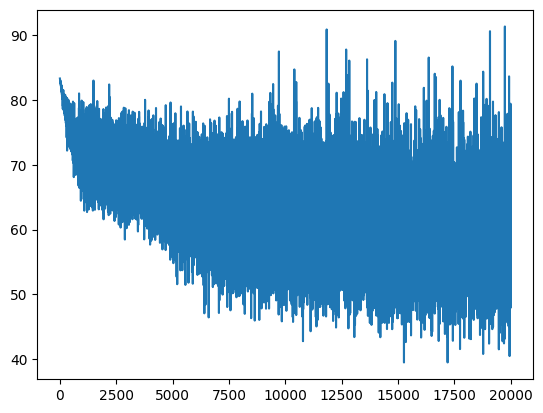

In [60]:
plt.plot(steps, lossi)

In [126]:
print(Wxh.grad.max(), Wxh.grad.min())

tensor(0.) tensor(0.)


In [19]:
def sample(seed_idx, length=20):
    h = torch.zeros(hidden_size, 1)
    x = torch.zeros(vocab_size, 1)
    x[seed_idx] = 1
    output = []
    for t in range(length):
        h = torch.tanh(Wxh @ x + Whh @ h + bh)
        y = Why @ h + by
        p = f.softmax(y, dim=0)
        idx = torch.multinomial(p.view(-1), 1).item()
        x = torch.zeros(vocab_size, 1)
        x[idx] = 1
        output.append(idx)
    return output


In [20]:
sample_text = sample(seed_idx=stoi['s'], length=100)
sample_text_str = ''.join(itos[idx] for idx in sample_text)

In [21]:
sample_text_str

'u ky brunch ke liy brunch ke liy brunch ke liy beunch ke liy brunch ke liy brunch ke liy brunch ke l'

In [171]:
Xtrain[0]

tensor([ 1, 13,  0, 11, 15,  0, 19, 21, 14,  4,  1, 25,  0,  2, 18, 21, 14,  3,
         8,  0, 11,  5,  0, 12,  9])

In [ ]:
stoi[Xtrain[0].item()]

KeyError: tensor([ 1, 13,  0, 11, 15,  0, 19, 21, 14,  4,  1, 25,  0,  2, 18, 21, 14,  3,
         8,  0, 11,  5,  0, 12,  9])